# Patient Readmission Exploration
#### Author: Izzy Valdivia
##### November 2025

### Project Background: 
&nbsp;&nbsp;&nbsp;&nbsp; Patient readmission is a powerful indicator of quality of care across the healthcare industry. Readmission is when a person is admitted to the hospital within 30 days of a previous discharge because there was some aspect of their care that was not handled or their condition is worsening. Health care providers and insurers frequently track patient readmission rates from hospital systems to better understand the quality of care provided at those facilities and how that affects patient outcomes. Understanding which hospitals have high readmission rates can help policymakers and insurers launch targeted improvement programs or understand what areas may need more resources. Definitive Healthcare, an analytics company focused on reporting on healthcare metrics in the United States, reports that the average hosiptal readmission rate is ~14.7%, with a range from 10.1 to 19.1% ([Definitive Healthcare, 2025](https://www.definitivehc.com/resourcesz/healthcare-insights/average-hospital-readmission-state#:~:text=What%20is%20the%20average%20hospital,to%2019.1%25%20in%20the%20U.S.)).  
&nbsp;&nbsp;&nbsp;&nbsp; With this context in mind, I am interested in creating a model to predict hospital readmission rates based on quality of care metrics for the Medicare population. I hope to understand what facets of quality of care most impact patient readmission rate for medicare patients. To do this I would most likely perform a regression analysis of readmission rate for each hospital/care system and their corresponding care metrics. Understanding the relationships between patient readmission and quality of care could also help policymakers adjust provider and insurer incentive structures to prioritize the health of individuals.

### Related Work: 
&nbsp;&nbsp;&nbsp;&nbsp; There has been some research done about hospital readmission rate that is tangential to the analysis I am aiming to complete. A paper published in 2020 found that looking at a specific subset of care quality measures, specifically patient satisfaction, leads to lower readmissions rates (Chen et al., 2020). Similarly, the Agency for Healthcare Research and Quality came out with a Re-Engineered Discharge toolkit that predicts a hospital’s readmission rate based on their member mix. While both of these resources analyze how certain healthcare factors affect a hospital’s readmission rate, I would like to examine this issue with a more comprehensive view. This project will be a multi-faceted approach to examining readmission rates using both clinical factors like timeliness while also incorporating structural aspects such as hospital funding sources and the type of hospital.

### Research Questions: 
In order to explore the relationship between hospital quality of care metrics and their patients’ corresponding readmissions rates, I will base my analysis on the following questions: 
* What are the current patterns and distributions of patient readmission rates across the Medicare hospitals and how do they vary by hospital type, funding source, size and location? 
* What quality of care metrics, like timeliness, patient experience, and emergency room wait times are most strongly associated with readmission rate?
* How effective can a multivariate regression model predict readmission rates based on the available quality of care metrics and structural aspects of the hospitals, and how does this prediction power compare across the different types of hospitals?



### Data Sources:  
&nbsp;&nbsp;&nbsp;&nbsp;All data collected for this project came [data.cms.gov](data.cms.gov). First of which is the [Hospital General Information dataset](https://data.cms.gov/provider-data/dataset/xubh-q36u#overview) which contains information on all hospitals that have registered with Medicare. Some of the information in this dataset includes address, type of hospital, ownership type (i.e. non-profit, government) and overall rating. Next I will be using the [Hospital Readmissions Reduction Program (HRRP)](https://data.cms.gov/provider-data/dataset/9n3s-kdb3) dataset, which includes information about the number of discharges, number of readmissions, and ratio of readmissions for each facility that is registered with Medicare. The readmission rate would be the outcome variable for the predictive model. Next, I will be using the [Timely and Effective Care](https://data.cms.gov/provider-data/dataset/yv7e-xc69) table that contains information on how hospitals perform on a variety of clinical measures like average time patients wait to be seen in the emergency department and appropriate care rating given to patients with sepsis. These measures are available for each of the hospitals that are registered with Medicare, so the measure ratings could be used as predictors for readmission rate. The license for all of these data sets is not explicitly stated, but according to an FAQ guide for using data from data.cms.gov, “Works of the U.S. Government are in the public domain and you don’t need permission to reuse them, but an attribution to the agency as the source is appreciated.” 

This analysis is being done in November 2025. Data version information is as follows: 

| Table | CSV Name | Last Updated | Release Date | 
| -------- | ------- | ------- | ------- |
| Hospital General Information | Hospital_General_Information.csv | 07-16-2025 | 08-06-2025 |
| Hospital Readmissions Reduction Program | FY_2025_Hospital_Readmission_Reduction_Program_Hospital.csv | 01-08-2025 | 08-06-2025 |
| Timely and Effective Care | Timely_and_Effective_Care-Hospital.csv | 07-24-2025 | 08-06-2025 |

### Methodology: 
&nbsp;&nbsp;&nbsp;&nbsp;In order to carry out the investigation outlined in the research questions section of this plan, I will do the following. First, I will do an exploratory analysis of the data and analyze the distribution of readmission rates and sizes of all registered Medicare hospitals. This will help establish a baseline understanding of the data that can be referenced along with my further analyses.  
&nbsp;&nbsp;&nbsp;&nbsp;Next, to answer the second research question about identifying which quality of care metrics are most associated with large readmission rates, I will perform a correlation analysis. This will identify which, if any, of the quality of care metrics are correlated with readmissions and whether or not that correlation is positive or negative. In the case there are many correlated predictor variables I will use LASSO to select only a subset of the most important variables. Important meaning the variables that explain the most variability in the outcome variable.   
&nbsp;&nbsp;&nbsp;&nbsp;Finally, to address the third research question, I will fit a multivariate logistic regression model as well as a random forest model with the quality of care and hospital-specific variables as the predictors. I will compare the R^2, RMSE and MAE values across both model types to evaluate which is the better predictor. Similarly, I will evaluate the models for interpretability. 


In [1]:
import polars as pl
import pandas as pd 
import matplotlib.pyplot as plt
import textwrap

| Table | CSV Name | Unique Facility IDs | Num Rows | Num Columns |
| -------- | ------- | ------- | ------- | ------- |
| Hospital General Information | Hospital_General_Information.csv | 5381 | 5381 | 38 |
| Hospital Readmissions Reduction Program | FY_2025_Hospital_Readmission_Reduction_Program_Hospital.csv | 3085 | 18510 | 12 |
| Timely and Effective Care | Timely_and_Effective_Care-Hospital.csv | 4623 | 117933 | 16 |

In [2]:
# HELPER FUNCTIONS: 
def get_dataset_stats(table, name): 
    table_shape = table.shape
    table_rows = table_shape[0]
    table_cols = table_shape[1]

    print(f"The {name} table has has {table_rows} rows and {table_cols} columns")

def create_distribution(data_frame, variable_name, label_name, sorted=False, sorting_col='none', title_flag=False, title="none", rotation=0, bar_color='skyblue'):
    avar = variable_name

    if sorted: 
        grouped_df_counts = data_frame.group_by(avar).agg(
            pl.len().alias(f"{label_name}_count"), 
            pl.col(sorting_col).first().alias("sort_order")
        )
        grouped_df_counts = grouped_df_counts.sort("sort_order")
    else: 
        grouped_df_counts = data_frame.group_by(avar).agg(
            pl.len().alias(f"{label_name}_count"), 
        )
        grouped_df_counts = grouped_df_counts.sort(avar)

    categories = grouped_df_counts[avar]
    category_counts = grouped_df_counts[f"{label_name}_count"]
    
    fig, ax = plt.subplots(figsize=(10, 5)) # Increase figure width
    bars = ax.bar(categories, category_counts)
    ax.bar_label(bars)
    ax.bar(categories, category_counts)
    ax.set_xlabel(label_name)
    plt.xticks(rotation=rotation)
    plt.gca().set_xticklabels(
    [textwrap.fill(label.get_text(), 12) for label in plt.gca().get_xticklabels()]
)

    ax.set_ylabel(f"{label_name} Count")
    if title_flag:
        plt.title(title)
    else:
        plt.title(f"Distribution of {label_name}")
    plt.show()


def quartile_statistics(df,col): 
    print(df.filter(pl.col(col) != "N/A").select(
    pl.col(col).cast(pl.Float64).quantile(0.25).alias(f"Q1 {col}"),
    pl.col(col).cast(pl.Float64).mean().alias(f"Mean {col}"), 
    pl.col(col).cast(pl.Float64).quantile(0.75).alias(f"Q3 {col}")
    ))



In [3]:
#### Load in Datasets
# Hospital General Information
hgi = pl.read_csv('../data/Hospital_General_Information.csv')
get_dataset_stats(hgi, "hgi")

# Readmission Reduction Program
rrp = pl.read_csv('../data/FY_2025_Hospital_Readmissions_Reduction_Program_Hospital.csv', schema_overrides={'Facility ID': pl.String})
get_dataset_stats(rrp, "RRP")

# Timely and Effective Care
tec = pl.read_csv('../data/Timely_and_Effective_Care-Hospital.csv', schema_overrides={'Facility ID': pl.String})
get_dataset_stats(tec, "tec")


The hgi table has has 5381 rows and 38 columns
The RRP table has has 18510 rows and 12 columns
The tec table has has 117933 rows and 16 columns


In [4]:
facilities_tec = tec['Facility ID'].unique().shape[0]
facilities_hgi = hgi['Facility ID'].unique().shape[0]
facilities_rrp = rrp['Facility ID'].unique().shape[0]

print(f"The number of unique facility IDs in the Timeliness and Effective Care dataset is {facilities_tec}")
print(f"The number of unique facility IDs in Hospital General Information dataset is {facilities_hgi}")
print(f"The number of unique facility IDs in Readmissions Reduction Program dataset is {facilities_rrp}")


# print(f"numrows of tec is {tec_rows}")

The number of unique facility IDs in the Timeliness and Effective Care dataset is 4623
The number of unique facility IDs in Hospital General Information dataset is 5381
The number of unique facility IDs in Readmissions Reduction Program dataset is 3085


The Readmissions Reduction Program dataset was last updated in January, the most distant of the 3 datasets. It also has the lowest number of unique hospital Facility IDs (Primary Key), so I'm checking to make sure both the Timely and Effective Care as well as the Hospital General Information tables have all of the Facility IDs contained in the RRP dataset. 


## Pre-processing: 
I am beginning by doing some minor pre-processing of the TEC data frame. I will be filtering to include data that has a start date of 1/1/2023 and and end date at the end of '23. This is because the RRP dataset only includes data through June 2023, therefore I will be filtering out the TEC dataframe's data from 2024. 

In [5]:
# Filter to specific year in TEC file:
tec_2023 = tec.filter(pl.col('Start Date') == "01/01/2023")

# Filter to specific readmission type in RRP file: 
heart_attack_rrp = rrp.filter(pl.col("Measure Name") == "READM-30-AMI-HRRP")


### Create merged table: 
Left join with filtered TEC table on the Facility ID column followed by a left join with the HGI table on Facility ID. 

In [6]:
# len(set(hgi['Facility ID'].unique()).intersection(set(rrp['Facility ID'].unique()))) == len(set(tec['Facility ID'].unique()).intersection(set(rrp['Facility ID'].unique())))

rrp_tec = heart_attack_rrp.join(tec_2023, on='Facility ID', how='left', suffix='_tec')


full_table = rrp_tec.join(hgi, on='Facility ID', how='left', suffix='_hgi')

### Remove redundant columns
There are some columns that repeat between the 3 datasets like Facility Name, Address, State and Telephone Number. 

In [7]:
cols=[]
for col in full_table.columns:
    cols.append(col)

for col in cols: 
    if "_" in col: 
        print(col)

cols_to_remove = [
    "Facility Name_tec",
    "Facility Name_hgi",
    "State_tec", 
    "Address_hgi",
    "City/Town_hgi",
    "State_hgi",
    "ZIP Code_hgi", 
    "County/Parish_hgi",
    "Telephone Number_hgi"
    ]


Facility Name_tec
State_tec
Measure Name_tec
Footnote_tec
Start Date_tec
End Date_tec
Facility Name_hgi
Address_hgi
City/Town_hgi
State_hgi
ZIP Code_hgi
County/Parish_hgi
Telephone Number_hgi


In [8]:
reduced_full = full_table.select(pl.exclude(cols_to_remove))
reduced_full.head(1)

Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date,Address,City/Town,ZIP Code,County/Parish,Telephone Number,Condition,Measure ID,Measure Name_tec,Score,Sample,Footnote_tec,Start Date_tec,End Date_tec,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for birthing friendly designation,Hospital overall rating,Hospital overall rating footnote,MORT Group Measure Count,Count of Facility MORT Measures,Count of MORT Measures Better,Count of MORT Measures No Different,Count of MORT Measures Worse,MORT Group Footnote,Safety Group Measure Count,Count of Facility Safety Measures,Count of Safety Measures Better,Count of Safety Measures No Different,Count of Safety Measures Worse,Safety Group Footnote,READM Group Measure Count,Count of Facility READM Measures,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,READM Group Footnote,Pt Exp Group Measure Count,Count of Facility Pt Exp Measures,Pt Exp Group Footnote,TE Group Measure Count,Count of Facility TE Measures,TE Group Footnote
str,str,str,str,str,i64,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,i64,str,str,i64
"""SOUTHEAST HEALTH MEDICAL CENTE…","""010001""","""AL""","""READM-30-AMI-HRRP""","""296""",null,"""0.9483""","""13.0146""","""13.7235""","""36""","""07/01/2020""","""06/30/2023""","""1108 ROSS CLARK CIRCLE""","""DOTHAN""",36301,"""HOUSTON""","""(334) 793-8701""","""Emergency Department""","""EDV""","""Emergency department volume""","""high""",null,null,"""01/01/2023""","""12/31/2023""","""Acute Care Hospitals""","""Government - Hospital District…","""Yes""","""Y""","""4""",null,"""7""","""7""","""0""","""7""","""0""",null,"""8""","""7""","""3""","""4""","""0""",null,"""11""","""11""","""0""","""11""","""0""",null,"""8""","""8""",null,"""12""","""11""",null


## Research Question # 1: 
* What are the current patterns and distributions of patient readmission rates across the Medicare hospitals and how do they vary by hospital type, funding source, size and location? 
    

/var/folders/d_/hxjmz8y17js99kwby_186kcc0000gn/T/ipykernel_9283/85110350.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(


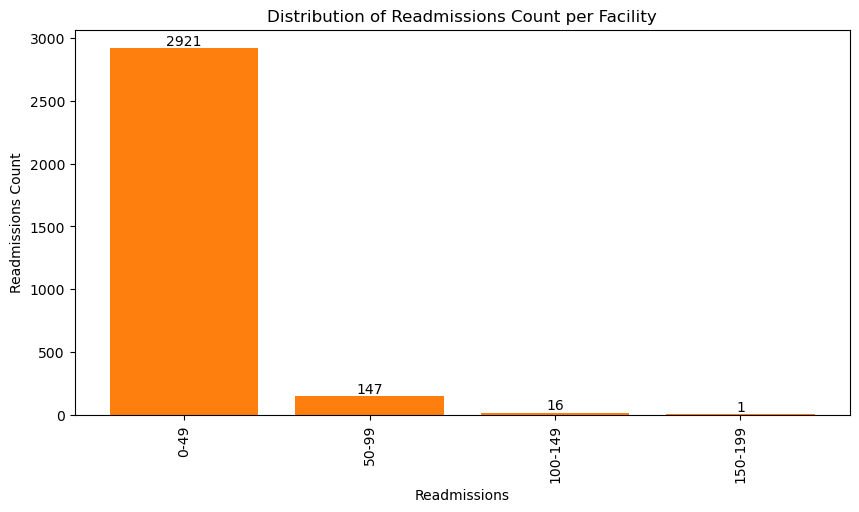

In [9]:
num_read ="Number of Readmissions"
tnr = "total_num_readmissions"
rfn = "readmissions_floor_num"
rrp_altered = heart_attack_rrp.with_columns(
    pl.when(pl.col(num_read).str.contains(r"[a-z]", strict=False) |
        (pl.col(num_read) == "N/A"))
      .then(0)
      .otherwise(pl.col(num_read))
      .alias(num_read)
)
grouped_rrp = rrp_altered.group_by("Facility ID").agg(
    pl.col(num_read).cast(pl.Int64).sum().alias(tnr)
)

df_binned = (
    grouped_rrp
    .with_columns(
        pl.col(tnr).cast(pl.Int64)
    )
    .with_columns(
        (pl.col(tnr) // 50 * 50)
            .alias(rfn)
    )
    .with_columns(
        (
            pl.col(rfn).cast(pl.Utf8)
            + "-"
            + (pl.col(rfn) + 49).cast(pl.Utf8)
        ).alias("readmissions_floor")
    )
)


create_distribution(df_binned, 
                    'readmissions_floor', 
                    "Readmissions", 
                    True, 
                    tnr,
                    True,
                    "Distribution of Readmissions Count per Facility",
                    90
                )


Get distribution of the Number of Hosiptals in each state:

In [ ]:
create_distribution(hgi, "State", "State", rotation=90, title_flag=True, title="Number of Hospitals per State")

Get the distribution of Hospital Types

In [ ]:
create_distribution(hgi, "Hospital Type", "Hospital Type", title_flag=True, title="Hospital Types")

Get the Distribution of number of hospitals by ownership type

In [ ]:
create_distribution(hgi, "Hospital Ownership", "Hospital Ownership", title_flag=True, title="Counts of Hospital Ownership Types", rotation=90)

In [ ]:
# Get the average predicted readmission rate as well as the quartiles
quartile_statistics(heart_attack_rrp, 'Predicted Readmission Rate')


shape: (1, 3)
┌───────────────────────────────┬─────────────────────────────────┬───────────────────────────────┐
│ Q1 Predicted Readmission Rate ┆ Mean Predicted Readmission Rat… ┆ Q3 Predicted Readmission Rate │
│ ---                           ┆ ---                             ┆ ---                           │
│ f64                           ┆ f64                             ┆ f64                           │
╞═══════════════════════════════╪═════════════════════════════════╪═══════════════════════════════╡
│ 12.1661                       ┆ 13.555663                       ┆ 14.7271                       │
└───────────────────────────────┴─────────────────────────────────┴───────────────────────────────┘


In [30]:
# heart_attack_rrp
reduced_hgi_anova = hgi.select(["Facility ID", "Hospital Type", "Hospital Ownership"])
heart_attack_rrp_hgi = heart_attack_rrp.join(reduced_hgi_anova, on="Facility ID", how="left")

heart_attack_rrp_hgi["Hospital Ownership"].unique()


Hospital Ownership
str
"""Government - State"""
"""Government - Local"""
"""Physician"""
"""Proprietary"""
"""Voluntary non-profit - Private"""
…
"""Government - Federal"""
"""Voluntary non-profit - Church"""
"""Tribal"""


In order to analyze whether a hospital's type, funding type or location affect the readmission rate, I will perform an ANOVA test. In this case, the null hypothesis ($H_0$) is that there is no significant difference in any of the mean readmission rates between different hospital ownership types with an $\alpha$ value of 0.05. The alternative hypothesis ($H_a$) in this case would be that there is at least one group mean that is different from the others. As is the case with ANOVA tests, a large F-statistic coupled with a small p-value (< $\alpha$) is enough evidence to reject $H_0$. A large p-value and small F-statistic would not provide enough evidence to reject $H_0$. 

In [39]:
from scipy.stats import f_oneway

# Remove rows where hospital ownership type or readmission rate is null: 
heart_attack_rrp_hgi_filtered = heart_attack_rrp_hgi.filter(
    (pl.col("Hospital Ownership") != "N/A") & 
    (pl.col("Hospital Ownership").is_not_null()) & 
    (pl.col('Predicted Readmission Rate') != "N/A")
).with_columns(
    pl.col("Predicted Readmission Rate").cast(pl.Float64)
)

df = heart_attack_rrp_hgi_filtered.to_pandas()
grps = [d['Predicted Readmission Rate'] for _, d in df.groupby("Hospital Ownership")]
f_statistic, p_value = f_oneway(*grps)


# Display the results: 
print(f"The f statistic associated with the ANOVA test is: {round(f_statistic, 4)}")
print(f"The p-value associated with thte ANOVA test is: {round(p_value,10)}")

The f statistic associated with the ANOVA test is: 5.6754
The p-value associated with thte ANOVA test is: 8.87e-08


Given that there is a large F statistic and 